# Minimal Model

This notebook presents an agent-based model that simulates 

In [1]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

np.random.seed(42)

In [2]:
import os

if os.path.isdir("../notebooks/"):
    os.chdir("..")


from utils import viz, delta_function, classifier_train

from agent import Person

from model import VirusModel, VirusModel_baseline


## About the model


## Defining the model

We define a new agent type :class:`Person` by creating a subclass of :class:`Agent`.
This agent has two methods: :func:`setup` will be called automatically at the agent's creation,
and :func:`being_sick` will be called by the :func:`Model.step` function.
Three tools are used within this class:

- :attr:`Agent.p` returns the parameters of the model
- :func:`Agent.neighbors` returns a list of the agents' peers in the network
- :func:`random.random` returns a uniform random draw between 0 and 1



In [3]:
class Person(ap.Agent):
    
    def setup(self):  
        """ Initialize a new variable at agent creation. """
        # self.condition = 0  # Susceptible = 0, Infected = 1, Recovered = 2
        a = 5 # shape
        rng = np.random.default_rng()
        self.wealth = 1
        self.race = 0
            

        # fraud
        self.fraud = rng.binomial(1,self.p.fraud_rate,1)[0]
        self.fraud_pred = -1
        self.convicted = 0

        
        
    
            
            
    def convict_true(self):
        """ Conviction and Consequences"""
        rng = np.random.default_rng()
        if self.fraud == 1:
            if rng.binomial(1,self.p.conviction_rate) == 1:
                # pay fine, get on record, 
                self.wealth = self.wealth - (0.01)#(self.wealth*0.05)])
                self.convicted =+ 1
                self.fraud = rng.binomial(1,self.p.fraud_rate,1)[0]

        else:
            self.fraud = rng.binomial(1,self.p.fraud_rate,1)[0]
            


        
            


Next, we define our model :class:`VirusModel` by creating a subclass of :class:`Model`.
The four methods of this class will be called automatically at different steps of the simulation,
as described in :ref:`overview_simulation`.

In [4]:
class VirusModel_mvp(ap.Model):
    
    def setup(self): #before
        """ Initialize the agents and network of the model. """

#         # Create agents and network
        self.agents = ap.AgentList(self, self.p.agents, Person)
    

    def step(self): # during each step
        """ Define the models' events per simulation step. """
#         self.agents.fraud_algo()
#         self.agents.appeal()
        self.agents.convict_true()
#         self.agents.wealth_grow()
        



    def update(self):  # after each step
        """ Record variables after setup and each step. """
        self.agents.record('wealth')
        self.agents.record('fraud_pred')
        self.agents.record('fraud')
        self.agents.record('race')
        
        
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """

        
        # general wealth 
        wealth = sum((self.agents).wealth) / len((self.agents))
        
        self.report('wealth_total', sum((self.agents).wealth) )
        self.report('wealth', wealth)
#         self.report('fraud_rate', self.p.fraud_rate)
            
            
        

In [5]:
parameters = {

    'my_parameter':42,
    'agents': 100, #ap.IntRange(50, 150),
    'steps':100,
    'fraud_rate': ap.Range(0.,1),
#     'wealth_start': ap.Range(0.5,1), #ap.Range(-0.2, 0.2), # >0 more wealth higher appeal chance
    'conviction_rate': 1, #ap.Range(0,1), # ap.Range(0,1),
} 

sample = ap.Sample(
    parameters, 
    n=128, 
    method='saltelli', 
    calc_second_order=False
)


exp = ap.Experiment(VirusModel_mvp, sample, iterations=2, record = True)
results = exp.run()

Scheduled runs: 768
Completed: 768, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:01:53.888549


The measures in our :class:DataDict now hold one row for each simulation run.

We can use standard functions of the pandas library like :func:pandas.DataFrame.hist to look at summary statistics.
Sensitivity analysis

We can also display sensitivities by plotting average evaluation measures over our parameter variations.

In [6]:
# make the plot mathematically
x_coords = np.arange(0,1, 0.01)

math_calc = pd.DataFrame(
    {'x_coords': x_coords,
     'y_coords': [1 - x*0.01*100 for x in x_coords]
    })


fraud_rate


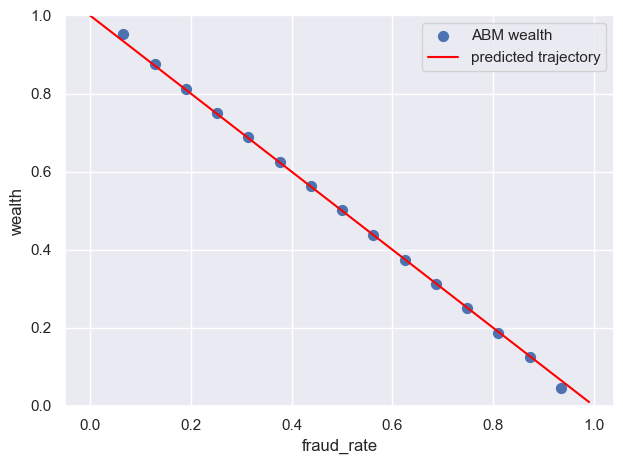

In [7]:
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """
    
    sns.set()
#     fig, axs = plt.subplots(2, 2, figsize=(8, 8))
#     axs = [i for j in axs for i in j] # Flatten list
    
    fig, ax = plt.subplots()
    
    data = results.arrange_reporters().astype('float')[["sample_id", "iteration", 'wealth', "fraud_rate"]]
    params = results.parameters.sample.keys() 

    for x in (params):
        for y in ['wealth']:
            print(x)
            sns.regplot(x=x, y=y, data=data, ci=99, 
                        x_bins=15, fit_reg=False, label= "ABM wealth")  
        ax.set_ylim(0,1)
        ax.set_ylabel('wealth')
        ax.legend()
        
    sns.lineplot(data = math_calc,y ='y_coords', x = 'x_coords', color = 'red', label = 'predicted trajectory')
        
    plt.tight_layout()

plot_sensitivity(results)